# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [28]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
#!pip install smdebug
#!pip install kaggle
!pip install kagglehub

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [6]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()
bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-438465162826
AWS Region: us-east-1
RoleArn: arn:aws:iam::438465162826:role/service-role/AmazonSageMaker-ExecutionRole-20250525T161111


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [18]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
# Fill in your user name and key from creating the kaggle account and API token file
import os
import json
kaggle_username = "danny123"
kaggle_key = "5d3c10745134cd54a15f110356c894b5"

kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

# Save API token the kaggle.json file
with open(kaggle_path, "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [29]:
#!kaggle datasets download sameeharahman/preprocessed-snake-images
#!unzip preprocessed-snake-images.zip -d snakeImages
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sameeharahman/preprocessed-snake-images")

100%|██████████| 1.11G/1.11G [00:05<00:00, 224MB/s] 

Extracting files...


In [31]:
import os

print("Downloaded path:", path)
print("Contents:")
print(os.listdir(path))


Downloaded path: /home/sagemaker-user/.cache/kagglehub/datasets/sameeharahman/preprocessed-snake-images/versions/1
Contents:
['preprocessed-cleaned-set']


In [32]:
import shutil

# Define source and target
src = "/home/sagemaker-user/.cache/kagglehub/datasets/sameeharahman/preprocessed-snake-images/versions/1/preprocessed-cleaned-set"
dst = "data/snakeImages"

# Create destination folder if not exists
os.makedirs(dst, exist_ok=True)

# Move contents from the source to the destination
for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
        shutil.move(s, d)
    else:
        shutil.copy2(s, d)

print("Moved data to:", dst)

Moved data to: data/snakeImages


In [33]:
for root, dirs, files in os.walk("data/snakeImages"):
    level = root.replace("data/snakeImages", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:3]:  # Show up to 3 files per folder
        print(f"{subindent}{f}")

snakeImages/
    train/
        class-1/
            00056e9548477cda7a885bb423cb668c.jpg
            001c80c16f964bb570d7eadcc09d0557.jpg
            00df0029772f1dd8e238a5bdca5a622b.jpg
            .ipynb_checkpoints/
                0a006d8501f3ec1dd144b9c68dc9f542-checkpoint.jpg
        class-2/
            000089388ad956f0c33694e569d90fa9.jpg
            0001dba9ce5553d72515c75cf728f155.jpg
            0002a258e95d10837e9574d808c2048c.jpg
        class-3/
            000436b50ac234dc752cba79cf65518c.jpg
            001ee87604e7cc850f5e78d423055f6c.jpg
            0022479dbc301b1595e8a664ab4e7649.jpg
        class-4/
            0005d03c317540343d7a1d0af7101c48.jpg
            001bfa21d5eb931a0d101ded5b06f346.jpg
            0024e94fe44fee56a66610f077297846.jpg
        class-5/
            00211adf56c52e867246185a40859aa2.jpg
            003ac4f44b5321a531892efddb91aa0d.jpg
            00548ee143a8cf8be55215248455c8c9.jpg


In [35]:
#count number of images in each folder
from glob import glob

# Path to your training directory
train_dir = "data/snakeImages/train"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue  # skip files like .DS_Store if any

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-1: 3087 images
class-2: 3661 images
class-3: 3547 images
class-4: 3453 images
class-5: 3641 images


In [37]:
###Move 10% to test
# Paths
import random
base_dir = "data/snakeImages/train"
test_dir = "data/snakeImages/test"
os.makedirs(test_dir, exist_ok=True)

# Set random seed for reproducibility
random.seed(42)

# Step 1 & 2: For each class folder
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    # Gather all image files (excluding .ipynb_checkpoints and non-images)
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    # Count and print
    print(f"{class_name}: {len(image_files)} images")

    # Determine 10% sample for test set
    num_test = max(1, int(0.1 * len(image_files)))  # At least one image
    test_samples = random.sample(image_files, num_test)

    # Create test/class_name folder
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move files
    for file_path in test_samples:
        filename = os.path.basename(file_path)
        shutil.move(file_path, os.path.join(test_class_dir, filename))

    print(f"→ Moved {num_test} images to test/{class_name}/")

print("\nDone splitting into train and test sets.")

class-1: 3087 images
→ Moved 308 images to test/class-1/
class-2: 3661 images
→ Moved 366 images to test/class-2/
class-3: 3547 images
→ Moved 354 images to test/class-3/
class-4: 3453 images
→ Moved 345 images to test/class-4/
class-5: 3641 images
→ Moved 364 images to test/class-5/

Done splitting into train and test sets.


In [38]:
train_dir = "data/snakeImages/train"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue 

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-1: 2779 images
class-2: 3295 images
class-3: 3193 images
class-4: 3108 images
class-5: 3277 images


In [39]:
test_dir = "data/snakeImages/test"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue  

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-1: 308 images
class-2: 366 images
class-3: 354 images
class-4: 345 images
class-5: 364 images


In [40]:
for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:3]:  # Show up to 3 files per folder
        print(f"{subindent}{f}")

data/
    snakeImages/
        train/
            class-1/
                00056e9548477cda7a885bb423cb668c.jpg
                001c80c16f964bb570d7eadcc09d0557.jpg
                00f42a37d55bf8d348bf616ed7603119.jpg
                .ipynb_checkpoints/
                    0a006d8501f3ec1dd144b9c68dc9f542-checkpoint.jpg
            class-2/
                000089388ad956f0c33694e569d90fa9.jpg
                0002a258e95d10837e9574d808c2048c.jpg
                001ae171e179190d7d23672a04560259.jpg
            class-3/
                000436b50ac234dc752cba79cf65518c.jpg
                001ee87604e7cc850f5e78d423055f6c.jpg
                0022479dbc301b1595e8a664ab4e7649.jpg
            class-4/
                0005d03c317540343d7a1d0af7101c48.jpg
                001bfa21d5eb931a0d101ded5b06f346.jpg
                0024e94fe44fee56a66610f077297846.jpg
            class-5/
                00211adf56c52e867246185a40859aa2.jpg
                003ac4f44b5321a531892efddb91aa0d.jpg
           

In [42]:
#upload to S3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./data/snakeImages/train s3://{bucket}/train/
!aws s3 sync ./data/snakeImages/test s3://{bucket}/test/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [49]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter,CategoricalParameter
from sagemaker.pytorch import PyTorch

In [50]:
hyperparameter_ranges = {
    'batch-size': CategoricalParameter([32, 64, 128]),
    'learning-rate': ContinuousParameter(0.0001, 0.01)
}
metric_definitions = [{'Name': 'test_loss','Regex': 'test_loss: ([0-9\\.]+)'}]
objective_metric_name = 'test_loss'
objective_type = 'Minimize'

In [53]:
#TODO: Create estimators for your HPs

estimator = PyTorch(entry_point = 'hpo.py',
                    base_job_name='hpo_snake_classify',
                    role=role,
                    py_version='py36',
                    framework_version="1.8",
                    instance_count=1,
                    instance_type="ml.m5.xlarge")

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [47]:
s3_input_path = f"s3://{bucket}/" 
s3_input_path

's3://sagemaker-us-east-1-438465162826/'

In [55]:
tuner.fit({"training": s3_input_path}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [64]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics

tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-250526-0739',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:438465162826:hyper-parameter-tuning-job/pytorch-training-250526-0739',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'test_loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning-rate',
     'MinValue': '0.0001',
     'MaxValue': '0.01',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch-size',
     'Values': ['"32"', '"64"', '"128"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'test_loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_module': '"sagemaker.pyt

In [65]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-250526-0739


In [66]:
best_estimator=tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-05-26 14:07:34 Starting - Found matching resource for reuse
2025-05-26 14:07:34 Downloading - Downloading the training image
2025-05-26 14:07:34 Training - Training image download completed. Training in progress.
2025-05-26 14:07:34 Uploading - Uploading generated training model
2025-05-26 14:07:34 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"test_loss"',
 'batch-size': '"128"',
 'learning-rate': '0.003953136913916208',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_snake_classify-2025-05-26-07-39-12-415"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-438465162826/hpo_snake_classify-2025-05-26-07-39-12-415/source/sourcedir.tar.gz"'}

In [72]:
best_estimator.hyperparameters()['batch-size'],best_estimator.hyperparameters()['learning-rate']

('"128"', '0.003953136913916208')

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [76]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig,ProfilerRule,CollectionConfig,rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


collection_configs = [
    CollectionConfig(
        name="train_loss",  # Custom collection for training loss
        parameters={"include_regex": ".*CrossEntropyLoss_output.*", "save_interval": "10"}
    ),
    CollectionConfig(
        name="eval_losses",  # Custom collection for evaluation loss
        parameters={"include_regex": ".*CrossEntropyLoss_output.*", "save_interval": "10"}
    )
]

In [77]:
hook_config = DebuggerHookConfig(collection_configs=collection_configs)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [71]:
hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
    "learning-rate": float(best_estimator.hyperparameters()['learning-rate'].replace('"', ''))
}
hyperparameters

{'batch-size': 128, 'learning-rate': 0.003953136913916208}

In [80]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='snake-classifier',  
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [81]:
#s3_input_path
estimator.fit({"training": s3_input_path}, wait=False)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: snake-classifier-2025-05-29-05-45-39-557


In [86]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-05-29 17:39:00.956 default:141 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/debug-output


In [87]:
trial.tensor_names()

[2025-05-29 17:39:06.678 default:141 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-05-29 17:39:07.696 default:141 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

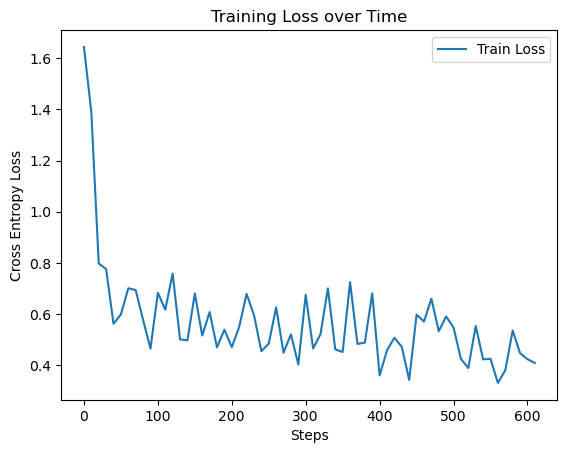

In [92]:
import matplotlib.pyplot as plt

# Example: Plot training loss
steps = trial.steps(mode=ModeKeys.TRAIN)
loss_vals = [trial.tensor("CrossEntropyLoss_output_0").value(step) for step in steps]

plt.plot(steps, loss_vals, label='Train Loss')
plt.xlabel("Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

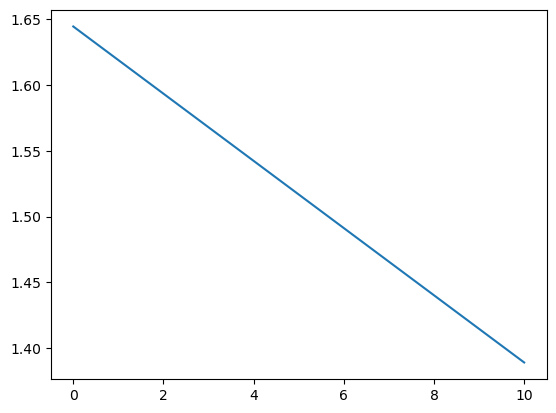

In [89]:
steps = trial.steps(mode=ModeKeys.EVAL)
loss_vals = [trial.tensor("CrossEntropyLoss_output_0").value(step) for step in steps]
plt.plot(steps, loss_vals, label='Eval Loss')
# plt.plot(steps, loss_vals, label='Train Loss')
# plt.xlabel("Steps")
# plt.ylabel("Cross Entropy Loss")
# plt.title("Training Loss over Time")
# plt.legend()
# plt.show()

In [94]:
len(loss_vals)

62

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [97]:
# TODO: Display the profiler output
#estimator.output_path,estimator.latest_training_job.job_name
#s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-report.html
prof_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [99]:
!aws s3 cp {prof_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-438465162826/sn

In [101]:
from IPython.display import IFrame

# Show the profiler report in an embedded frame
IFrame(src='./ProfilerReport/profiler-output/profiler-report.html', width=1000, height=600)

## Model Deploying

In [112]:
from sagemaker.pytorch import PyTorchModel

In [120]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model path: {model_data}")

Model path: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/output/model.tar.gz


In [121]:
# TODO: Deploy your model to an endpoint

pytorch_model = PyTorchModel(
    entry_point='inference.py',
    model_data=model_data, 
    role=role,
    framework_version='1.8',         # Match your local PyTorch version if needed
    py_version='py36'
)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge",endpoint_name='resnet50-snake-custom-endpoint')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-438465162826/pytorch-inference-2025-06-02-03-29-03-069/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-06-02-03-29-10-795
INFO:sagemaker:Creating endpoint-config with name resnet50-snake-custom-endpoint
INFO:sagemaker:Creating endpoint with name resnet50-snake-custom-endpoint


------!

In [109]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import requests
import base64
import io

In [142]:
# Pick a test image
test_image_path = './data/snakeImages/test/class-5/1c758f902321e876e21d47d0e9ce636e.jpg'  # Replace with your actual path

# Open image and convert to bytes
with open(test_image_path, 'rb') as f:
    payload = f.read()


In [141]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import StringDeserializer
predictor.deserializer = StringDeserializer()
predictor.serializer = IdentitySerializer(content_type='image/jpeg')

In [144]:
response=predictor.predict(payload)
print(response)

{"class_index": 4, "class_label": "Western Diamondback rattlesnake", "confidence": 0.973}


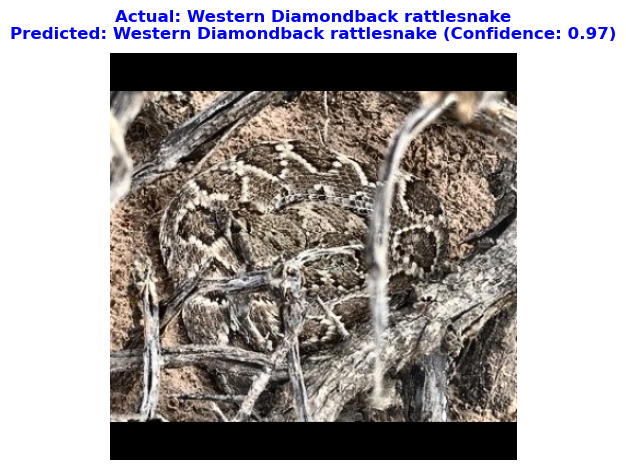

In [147]:
# Step 1: Define the label lookup
label_lookup = {
    0: "Northern Watersnake",
    1: "Common Garter snake",
    2: "DeKay's Brown snake",
    3: "Black Rat snake",
    4: "Western Diamondback rattlesnake"
}

# Step 2: Provide image path
test_image_path = './data/snakeImages/test/class-5/1c758f902321e876e21d47d0e9ce636e.jpg'

# Step 3: Extract actual class from image path
actual_class_index = int(test_image_path.split("class-")[1].split("/")[0])
actual_class_label = label_lookup[actual_class_index-1]

# Step 4: Read image bytes and send to endpoint
with open(test_image_path, 'rb') as f:
    payload = f.read()

response = predictor.predict(payload)
prediction = json.loads(response)

predicted_class_index = prediction["class_index"]
predicted_class_label = prediction["class_label"]
confidence = prediction["confidence"]

# Step 5: Show image and overlay actual vs predicted info
image = Image.open(test_image_path)

plt.imshow(image)
plt.axis("off")
plt.title(
    f"Actual: {actual_class_label}\n"
    f"Predicted: {predicted_class_label} (Confidence: {confidence:.2f})",
    fontsize=12,
    color='blue'
)
plt.show()

In [149]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: resnet50-snake-custom-endpoint
INFO:sagemaker:Deleting endpoint with name: resnet50-snake-custom-endpoint


In [148]:
test_image_path = './data/snakeImages/test/class-1/0b22ab2824da7b9db11b0ab563dfb1fb.jpg'  # Replace with your actual path

# Open image and convert to bytes
with open(test_image_path, 'rb') as f:
    payload = f.read()

response=predictor.predict(payload)
print(response)

{"class_index": 0, "class_label": "Northern Watersnake", "confidence": 0.993}
